# Field Validation

In [1]:

import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *
from utils.Plots import *


In [11]:
# # plot the combined data
df= pd.read_csv('../../data/test/Accelerometer_ziyi.csv')
df

,Date,NTP,GNSS-Time,Acc-X,Acc-Y,Acc-Z
0,2025-03-28T16:00:44.931,2025-03-28 16:00:48.289,1743174048272,1.781281,4.735733,8.374924
1,2025-03-28T16:00:44.935,2025-03-28 16:00:48.293,1743174048276,2.643204,5.118805,8.274368
2,2025-03-28T16:00:44.942,2025-03-28 16:00:48.300,1743174048285,2.097321,5.037399,7.814682
3,2025-03-28T16:00:44.945,2025-03-28 16:00:48.303,1743174048286,1.891418,5.061340,8.034943
4,2025-03-28T16:00:44.951,2025-03-28 16:00:48.308,1743174048292,2.892197,5.272034,7.891296
...,...,...,...,...,...,...
268724,2025-03-28T16:22:59.273,2025-03-28 16:23:02.631,1743175382614,2.863464,5.655106,7.546524
268725,2025-03-28T16:22:59.277,2025-03-28 16:23:02.636,1743175382619,2.145203,5.549759,7.067688
268726,2025-03-28T16:22:59.284,2025-03-28 16:23:02.642,1743175382625,2.815582,5.281616,8.034943
268727,2025-03-28T16:22:59.288,2025-03-28 16:23:02.646,1743175382629,2.987961,5.559341,8.226471


In [12]:
# # plot the combined data
df_curb= pd.read_csv('../../data/test/ESP_curb.csv')
# Create a list of indices to drop because not actuell curb
indices_to_drop = [0, 1, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 28, 31, 35, 
                  54, 56, 62, 65, 67, 70, 74, 77, 78, 79, 80, 83, 84, 87, 89, 90,
                  92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 106, 107, 108,
                  116, 117, 120, 122, 126, 127, 128, 129, 130, 135, 136, 137, 138, 139]

# Drop the specified indices
df_curb = df_curb.drop(indices_to_drop)

# Reset the index to make it sequential again
df_curb = df_curb.reset_index(drop=True)
df_curb


,Date,NTP,GNSS-Time,Value
0,2025-03-28T16:01:49.559,2025-03-28 16:01:52.917,1743174112903,Curb Up
1,2025-03-28T16:01:56.627,2025-03-28 16:01:59.985,1743174119969,Curb Up
2,2025-03-28T16:02:06.915,2025-03-28 16:02:10.274,1743174130257,Curb Up
3,2025-03-28T16:02:20.211,2025-03-28 16:02:23.569,1743174143552,Curb Up
4,2025-03-28T16:02:41.919,2025-03-28 16:02:45.277,1743174165260,Curb Up
...,...,...,...,...
75,2025-03-28T16:21:28.435,2025-03-28 16:21:31.793,1743175291776,Curb Up
76,2025-03-28T16:22:01.715,2025-03-28 16:22:05.073,1743175325057,Curb Up
77,2025-03-28T16:22:06.616,2025-03-28 16:22:09.974,1743175329957,Curb Up
78,2025-03-28T16:22:11.213,2025-03-28 16:22:14.571,1743175334554,Curb Up


In [14]:
matching_points = df[df['NTP'].isin(df_curb['NTP'])]
len(matching_points)

13

IndexError: index 0 is out of bounds for axis 0 with size 0

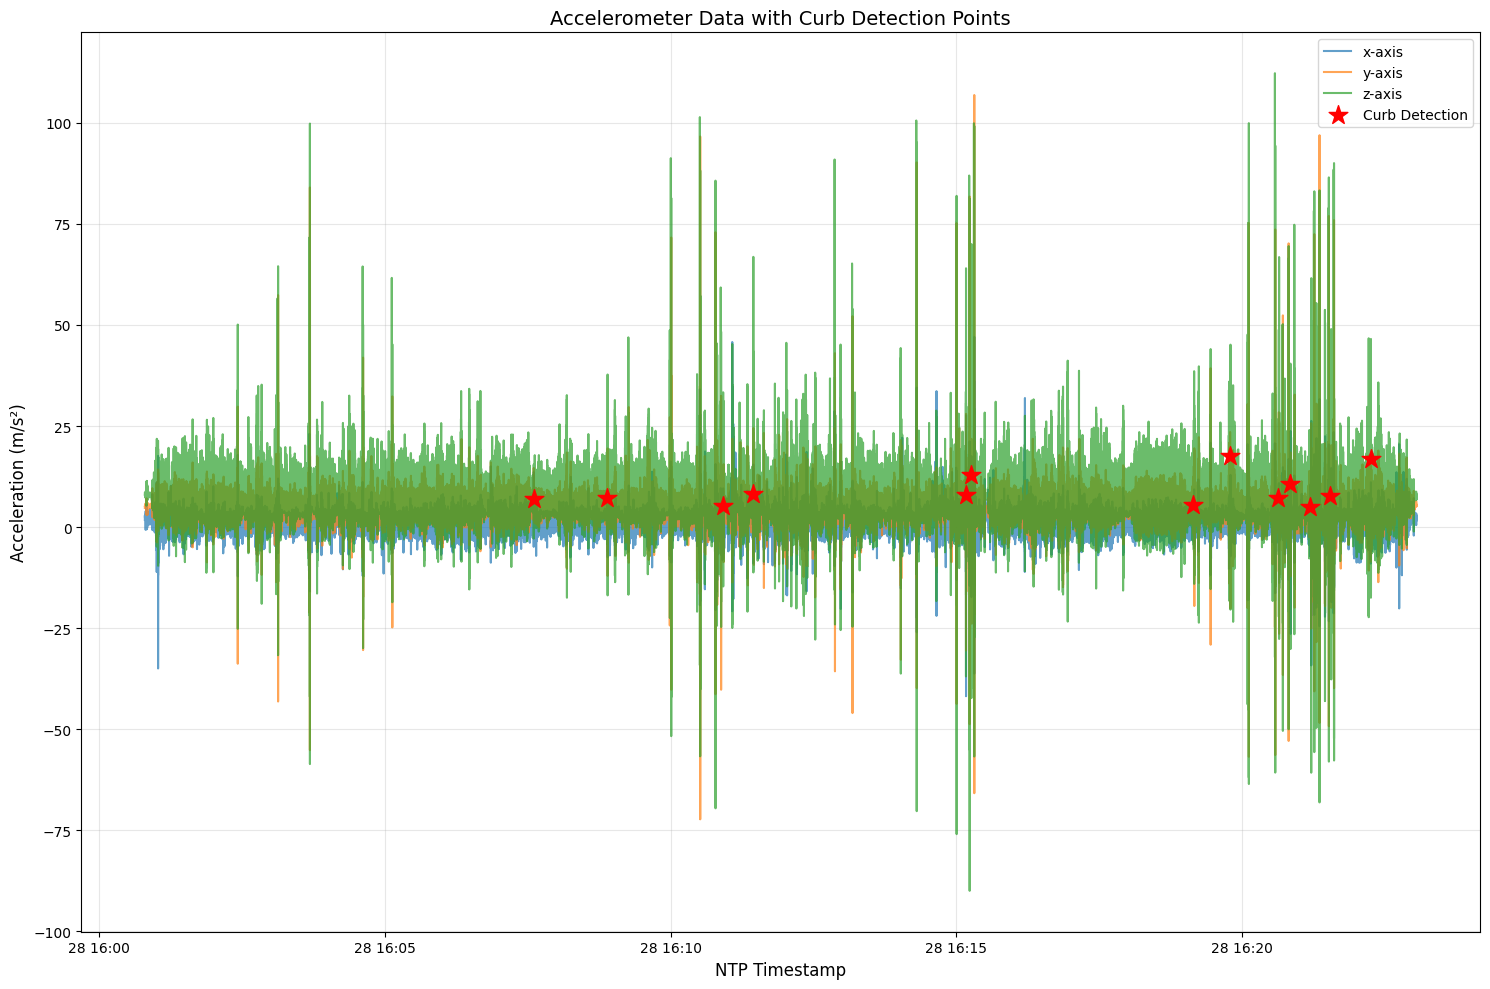

Number of curb detections found: 13


In [10]:
# Create figure and axis
plt.figure(figsize=(15, 10))

# Convert NTP columns to datetime
df_curb['NTP'] = pd.to_datetime(df_curb['NTP'])
df['NTP'] = pd.to_datetime(df['NTP'])

# Plot accelerometer data
plt.plot(df['NTP'], df['Acc-X'], label='x-axis', alpha=0.7)
plt.plot(df['NTP'], df['Acc-Y'], label='y-axis', alpha=0.7)
plt.plot(df['NTP'], df['Acc-Z'], label='z-axis', alpha=0.7)

# Find matching timestamps and mark them
matching_points = df[df['NTP'].isin(df_curb['NTP'])]
if not matching_points.empty:
    plt.scatter(matching_points['NTP'], matching_points['Acc-Z'],  # Changed 'z' to 'Acc-Z'
               color='red', marker='*', s=200, label='Curb Detection', zorder=5)

# Customize the plot
plt.title('Accelerometer Data with Curb Detection Points', fontsize=14)
plt.xlabel('NTP Timestamp', fontsize=12)
plt.ylabel('Acceleration (m/s²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Print number of matching points found
print(f"Number of curb detections found: {len(matching_points)}")